# Generative Adversarial Network 1 (from the GAN Writing paper)
In this notebook, we will show the results of our generative adversarial network which we trained accoarding to the GAN Writing paper. Graphs and metrics are shown aswell as the outputs from the model on style and text conditioned input.

# Data Preperations

In [ ]:
!nvidia-smi

Thu Jan  7 17:56:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
words_zip_path  = '/content/drive/My Drive/Final Project/Datasets/IAM/fixed_new_words.zip'
code_zip_path   = '/content/drive/My Drive/Final Project/Code Files/research-GANwriting-master.zip'

In [ ]:
!unzip "$code_zip_path" -d /content

In [ ]:
!mkdir /content/fixed_new_words
!unzip "$words_zip_path" -d /content/fixed_new_words

In [ ]:
%cd /content/research-GANwriting-master/
!pwd

/content/research-GANwriting-master
/content/research-GANwriting-master


In [ ]:
!pip install -r requirements.txt

# Test Section with Images

In [ ]:
from pairs_idx_wid_iam import label2wid_tr, label2wid_te

def test_writer(wid, model):
    splitted_words = list()

    def read_image(file_name):
        url = img_base + file_name + '.png'
        img = cv2.imread(url, 0)
       
        rate = float(IMG_HEIGHT) / img.shape[0]
        img = cv2.resize(img, (int(img.shape[1]*rate)+1, IMG_HEIGHT), interpolation=cv2.INTER_CUBIC) # INTER_AREA con error
        img = img/255. # 0-255 -> 0-1

        img = 1. - img
        img_width = img.shape[-1]

        if img_width > IMG_WIDTH:
            outImg = img[:, :IMG_WIDTH]
            img_width = IMG_WIDTH
        else:
            outImg = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype='float32')
            outImg[:, :img_width] = img
        outImg = outImg.astype('float32')

        mean = 0.5
        std = 0.5
        outImgFinal = (outImg - mean) / std
        return outImgFinal

    def label_padding(labels, num_tokens):
        new_label_len = []
        ll = [letter2index[i] for i in labels]
        new_label_len.append(len(ll)+2)
        ll = np.array(ll) + num_tokens
        ll = list(ll)
        ll = [tokens['GO_TOKEN']] + ll + [tokens['END_TOKEN']]
        num = OUTPUT_MAX_LEN - len(ll)
        if not num == 0:
            ll.extend([tokens['PAD_TOKEN']] * num) # replace PAD_TOKEN
        return ll

    def fix_single_letter(img, thresh=100):
        """
        Given an image of handwritten letter, attached to the character 'l'
        a counter and a threshold,
        Returns the fixed image that contains the deserved letter
        """

        c = 0
        flag = False

        for j in range(img.shape[1]-1, 0, -1):
            if flag:
                break
            col = img[:, j:j+1]
            for i in range(img.shape[0]):
                if col[i] < thresh:
                    c += 1
                    if c >= 5:
                        img = np.copy(img[:, 0:j-30])
                        flag = True

        for i in range(img.shape[1]-1, 0, -1):
            pixel = img[(img.shape[0] - 1) // 2, i]
            if pixel < thresh:
                return img[:, 0:i+5]


        return img

    def fix_long_word(word):
        """
        Given a word text that contains more than 10 letter
        splits the word into smaller words
        """

        if len(word) <= 10:
            return word
        
        center_pos = len(word) // 2
        splitted_words.append(fix_long_word(word[:center_pos]))
        splitted_words.append(fix_long_word(word[center_pos:]))


    '''data preparation'''
    imgs = [read_image(i) for i in data_dict[wid]]
    # random.shuffle(imgs)
    style_images = imgs[:50].copy()
    # style_images = imgs[0].copy()

    final_imgs = style_images.copy()
    # final_imgs = [style_images.copy() for i in range(50)]
    style_images = 255 - np.asarray(style_images) # Inverse images for plotting purposes

    if len(final_imgs) < 50:
        while len(final_imgs) < 50:
            num_cp = 50 - len(final_imgs)
            final_imgs = final_imgs + imgs[:num_cp]

    final_imgs = torch.from_numpy(np.array(final_imgs)).unsqueeze(0).to(gpu) # 1,50,64,216

    single_letter_locations, long_word_locations = list(), list()
    fixed_texts, texts = list(), list()
    global text_corpus
    with open(text_corpus, 'r') as _f:
        texts = _f.read().split()
        fixed_texts = list()
        for i, word in enumerate(texts):
            if len(word) <= 10:
                if len(word) == 1:
                    word += 'l'
                    single_letter_locations.append(i)
                fixed_texts.append(word)
            elif len(word) > 10:
                splitted_words = list()
                fix_long_word(word)
                fixed_texts += splitted_words
                long_word_locations.append((i, i+len(splitted_words)))

    labels = torch.from_numpy(np.array([np.array(label_padding(label, num_tokens)) for label in fixed_texts])).to(gpu)
   
    num = 0
    gen_images = []
    with torch.no_grad():
        f_xs = model.gen.enc_image(final_imgs)

        for label in labels:
            label = label.unsqueeze(0)

            f_xt, f_embed = model.gen.enc_text(label, f_xs.shape)
            f_mix = model.gen.mix(f_xs, f_embed)
            xg = model.gen.decode(f_mix, f_xt)
            pred = model.rec(xg, label, img_width=torch.from_numpy(np.array([IMG_WIDTH])))
            label = label.squeeze().cpu().numpy().tolist()
            pred = torch.topk(pred, 1, dim=-1)[1].squeeze()
            pred = pred.cpu().numpy().tolist()
            for j in range(num_tokens):
                label = list(filter(lambda x: x!=j, label))
                pred = list(filter(lambda x: x!=j, pred))
            label = ''.join([index2letter[c-num_tokens] for c in label])
            pred = ''.join([index2letter[c-num_tokens] for c in pred])
            ed_value = Lev.distance(pred, label)
            if ed_value <= 100:
                num += 1
                xg = xg.cpu().numpy().squeeze()
                xg = normalize(xg)
                xg = 255 - xg
                gen_images.append(xg)
                ret = cv2.imwrite(folder+'/'+wid+'-'+str(num)+'.'+label+'-'+pred+'.png', xg)
                if not ret:
                    import pdb; pdb.set_trace()
                    xg

    for loc in single_letter_locations:
        gen_images[loc] = fix_single_letter(gen_images[loc])

    return long_word_locations, gen_images, style_images

# Load Model and Input Files: (gan.iam.test.gt.filter27, in_vocab.subset.tro.37)

In [ ]:
import cv2
import Levenshtein as Lev
import random
import numpy as np
import torch
from network_tro import ConTranModel
from load_data import IMG_HEIGHT, IMG_WIDTH, NUM_WRITERS, letter2index, tokens, num_tokens, OUTPUT_MAX_LEN, index2letter
from modules_tro import normalize
import matplotlib.pyplot as plt
import os


'''Take turns to open the comments below to run 4 scenario experiments'''
WEIGHTS_PATH  = '/content/drive/MyDrive/Final Project/Models/Handwriting Generation/saved_weights/'
# model_path = WEIGHTS_PATH + 'contranCla-6000.model'
model_path = WEIGHTS_PATH + 'contran-10500.model'
# model_path = WEIGHTS_PATH + 'contran-10500Cla-NEW-1000.model'
folder = 'res_1.in_vocab_tr_writer'
img_base    = '/content/fixed_new_words/'
target_file = '/content/research-GANwriting-master/Groundtruth/gan.iam.test.gt.filter27'
text_corpus = '/content/research-GANwriting-master/corpora_english/in_vocab.subset.tro.37'
'''model loading'''
gpu = torch.device('cuda')
model = ConTranModel(500, 0, True).to(gpu)
# model = ConTranModel(1000, 0, True).to(gpu)
print('Loading ' + model_path)
model.load_state_dict(torch.load(model_path)) #load
print('Model loaded')
model.eval();

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth



Loading /content/drive/MyDrive/Final Project/Models/Handwriting Generation/saved_weights/contran-10500.model
Model loaded


# This is the actual Test (change wid to Look at different Writers)

In [ ]:
'''data preparation'''
data_dict = dict()
with open(target_file, 'r') as _f:
    data = _f.readlines()
    data = [i.split(' ')[0] for i in data]
    data = [i.split(',') for i in data]
for wid, index in data:
    if wid in data_dict.keys():
        data_dict[wid].append(index)
    else:
        data_dict[wid] = [index]

if not os.path.exists(folder):
    os.makedirs(folder)

In [ ]:
with open(target_file, 'r') as _f:
    data = _f.readlines()
wids = list(set([i.split(',')[0] for i in data]))
long_word_locations, location_per_writer, imgs, words_per_writer = list(), list(), list(), list()
styles = list()

for i in range(30, len(wids), 1):
    # long_word_locations, imgs = test_writer2(model=model)
    # long_word_locations, gen_imgs, style_images, cla_res = test_writer(wids[i], model=model)
    long_word_locations, gen_imgs, style_images = test_writer(wids[i], model=model)
    styles.append(style_images)
    # print("\ncla res:\n", cla_res, "\nground truth:\n", wids[i])
    location_per_writer.append(long_word_locations)
    # words_per_writer.append(imgs)
    words_per_writer.append(gen_imgs)
    if i == 45:
        break

In [ ]:
def crop_images(imgs):
  for i in range(len(imgs)):
    imgs[i] = crop_front_space(imgs[i])

def crop_front_space(img, thresh=5):
  # thresh is the number of black pixels seen in order to stop.
  count = 0
  for j in range(img.shape[1]-1, 0, -1):
    col = img[:, j:j+1]
    for i in range(img.shape[0]):
      if col[i] < 100:
        count += 1
        if count >= thresh:
          return img[:, 0:j + 10]
  return img

def add_words(page_img, word_imgs, space=20):
  
  W = page_img.shape[1]
  x = 5
  y = 0
  w_sum = 0
  for i in range(len(word_imgs)):
    h = word_imgs[i].shape[0]
    w = word_imgs[i].shape[1]
    if y + w >= W:
      x += h
      y = 0
    page_img[x:x+h, y:y+w] = word_imgs[i]
    y += w + space
    w_sum += y
   
  return page_img

In [ ]:
def fix_long_images(imgs, locs):
  if len(locs) > 0:
      new_imgs = list()
      offset = 0

      for s, e in locs:
          for i in range(s):
              new_imgs.append(imgs[offset + i])

          new_img = np.zeros((64 * 5, 216 * 6))
          new_img[:] = 255          
          new_imgs.append(crop_front_space(add_words(new_img, imgs[s:e], -90)))
          offset += e

      for i in range(e, len(imgs)):
          new_imgs.append(imgs[i])

      return new_imgs
  else:
      return imgs

# Plot of outputs of a sentence from the model - generated one word at a time and ensambled with an image proccessing algorithm, with style extracted from a set of given words plotted above every sentence

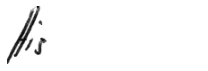

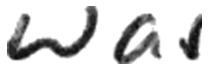

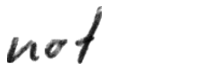

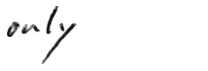

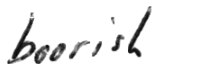

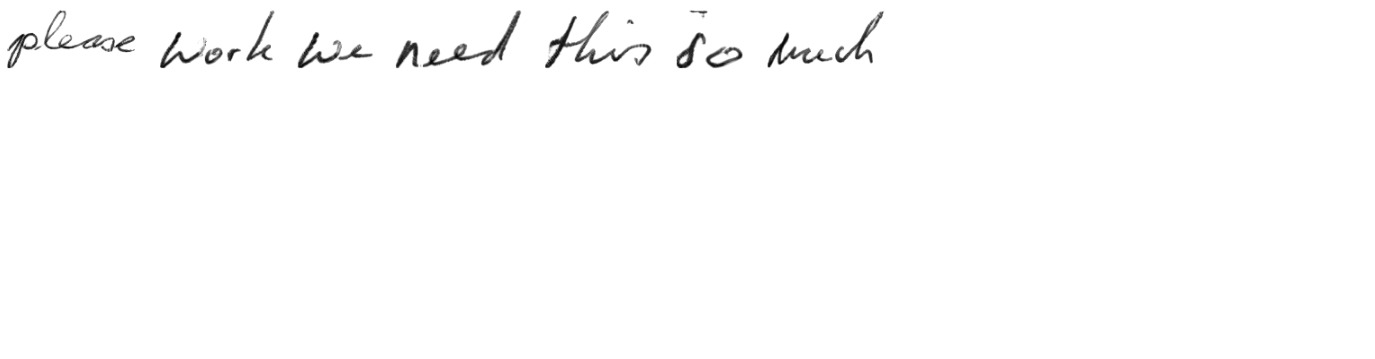

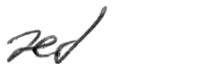

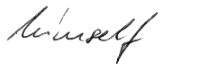

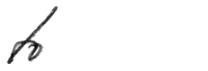

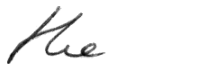

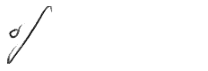

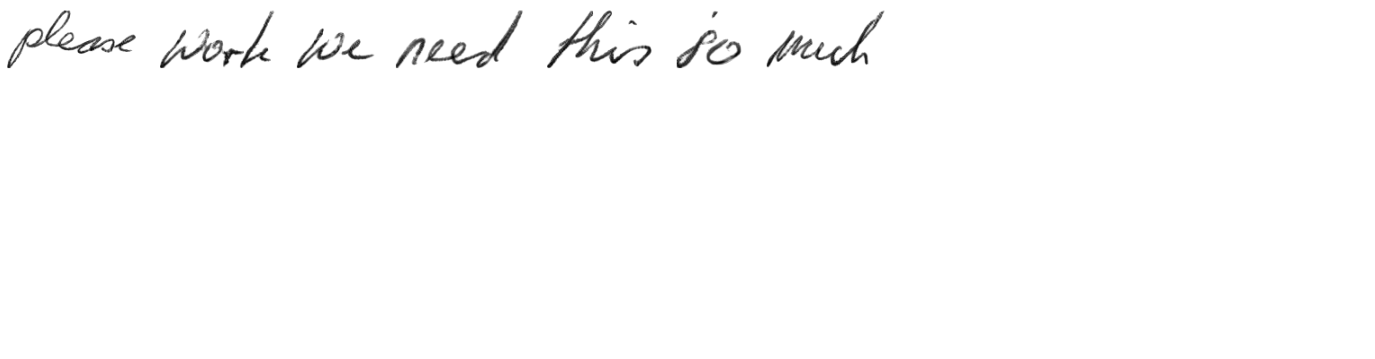

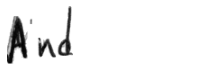

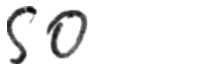

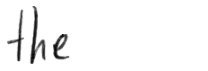

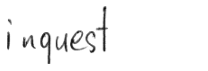

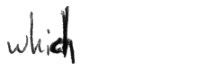

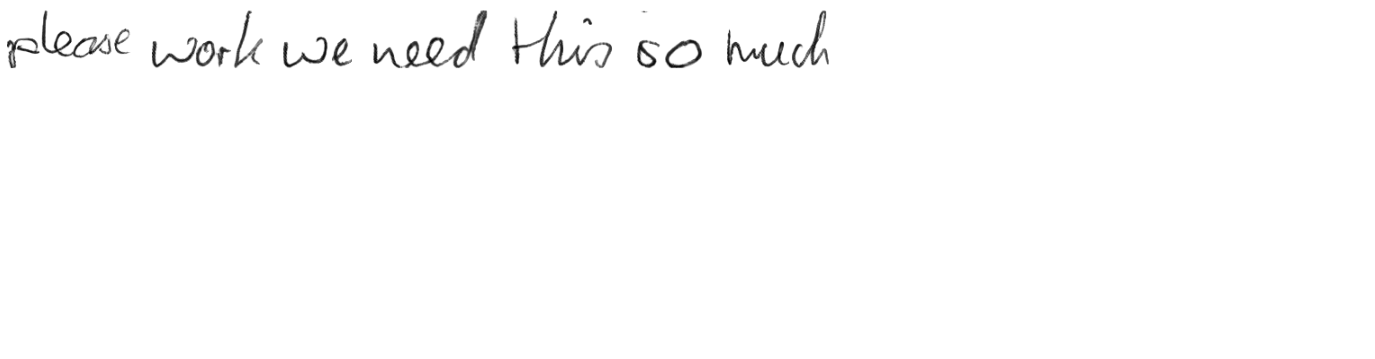

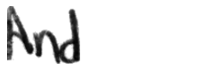

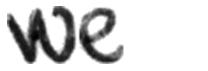

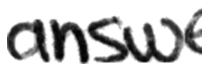

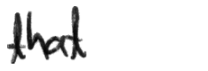

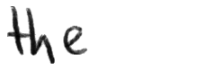

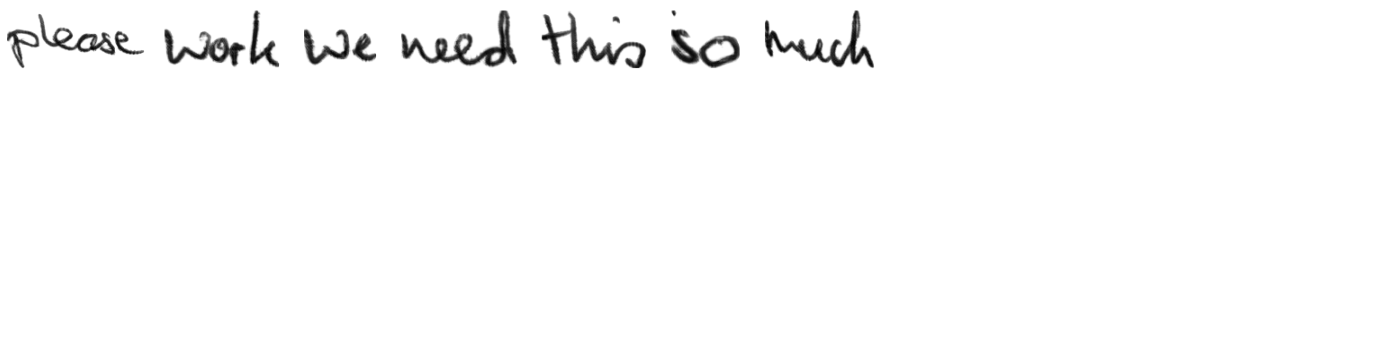

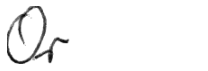

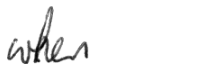

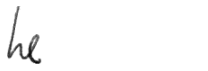

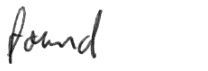

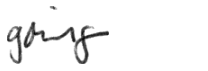

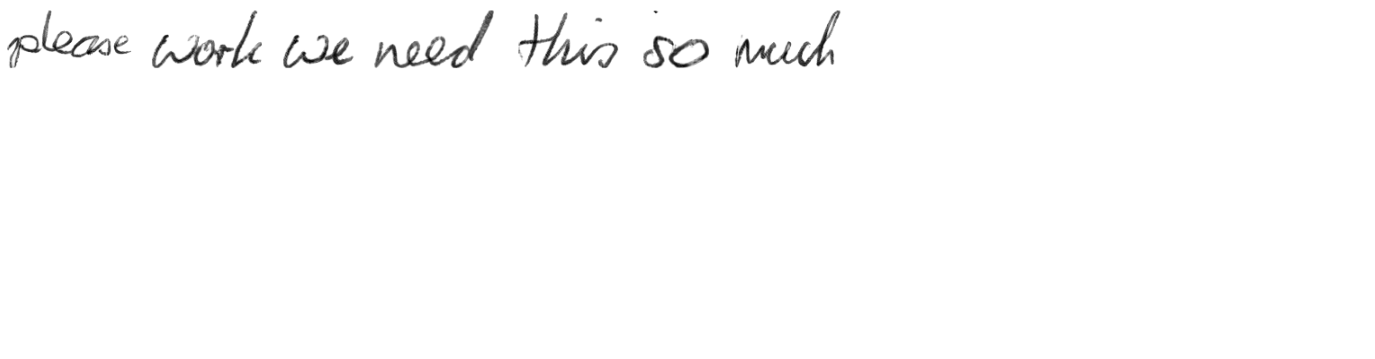

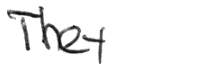

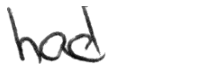

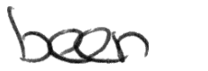

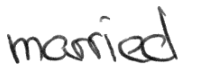

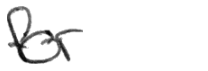

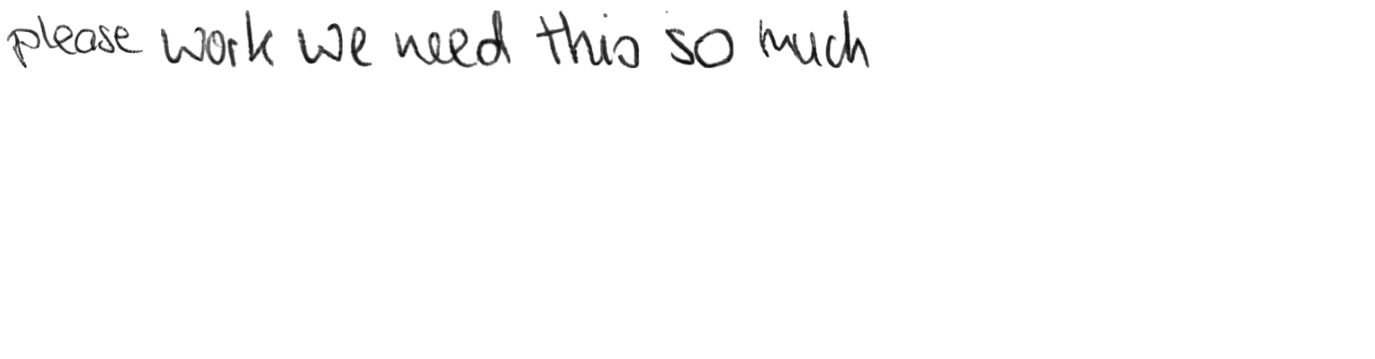

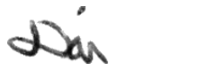

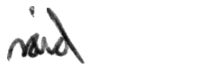

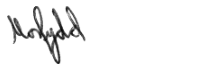

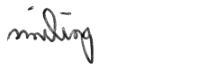

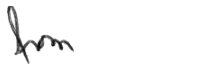

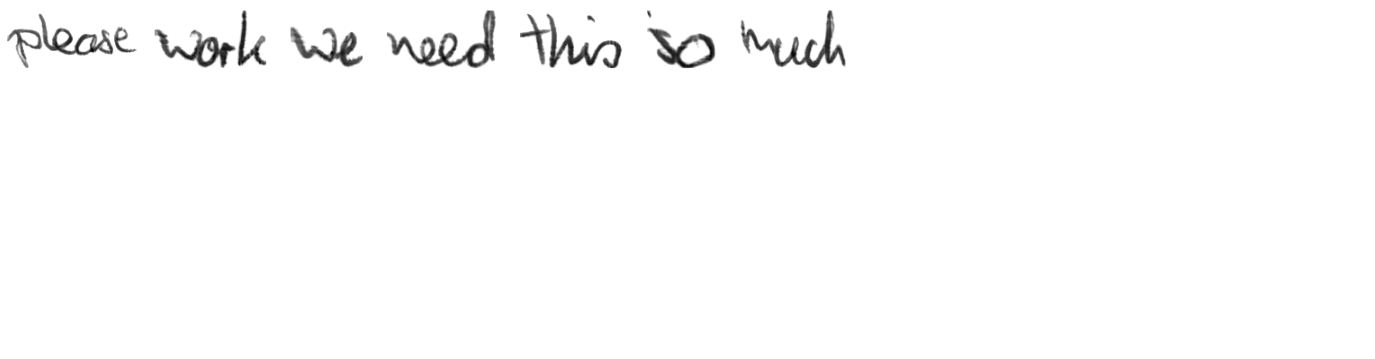

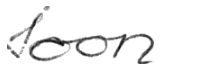

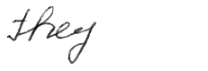

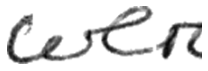

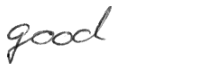

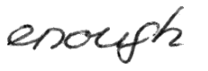

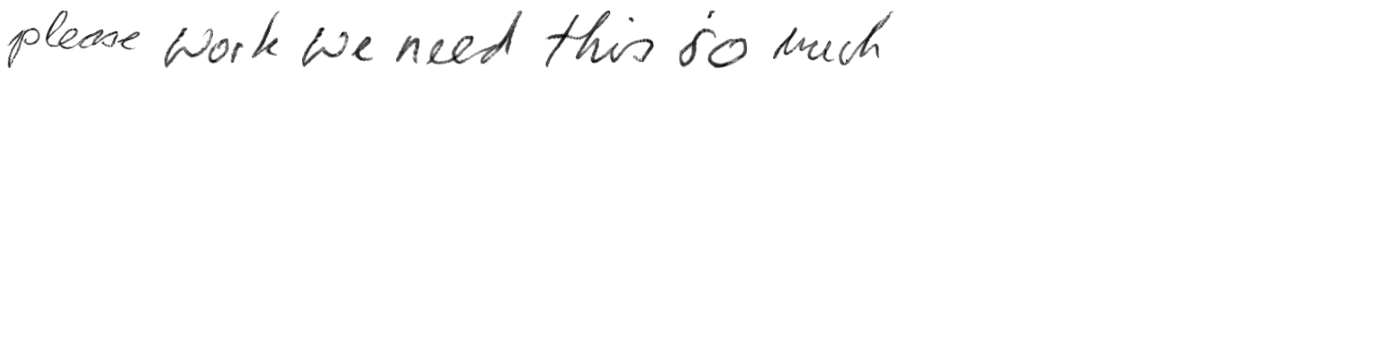

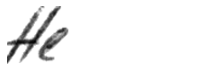

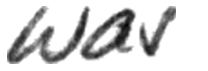

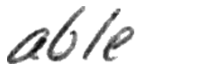

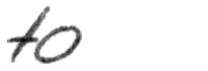

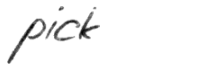

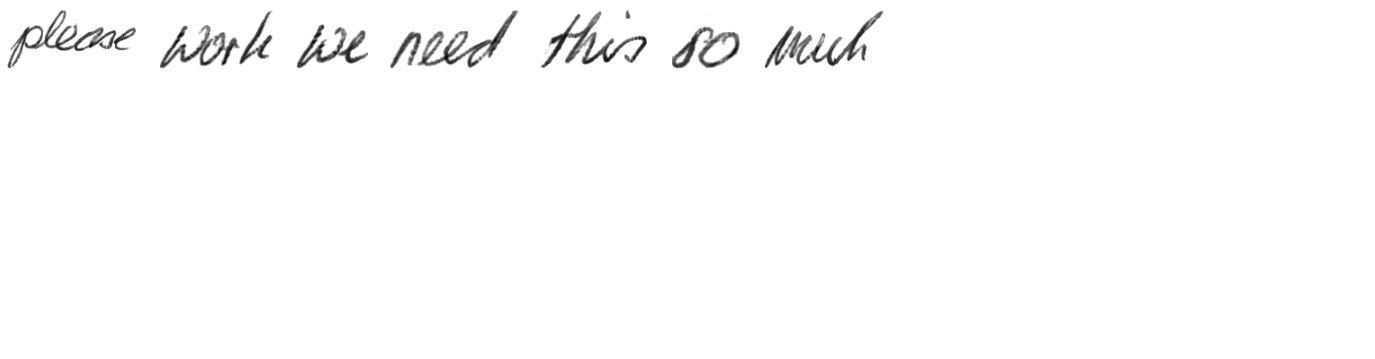

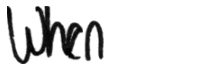

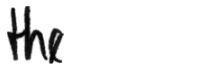

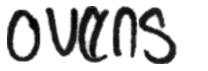

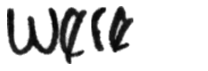

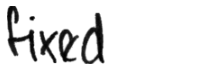

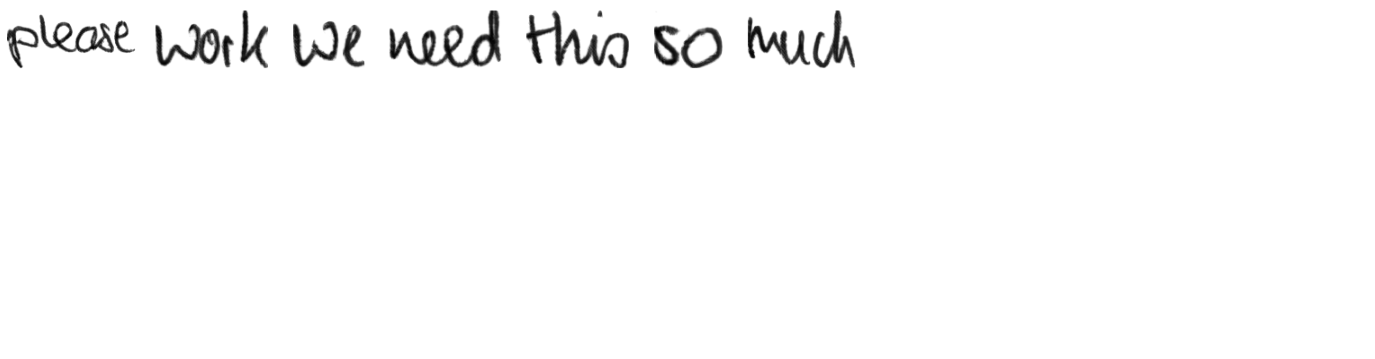

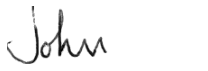

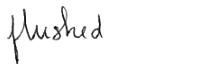

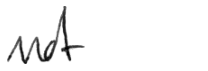

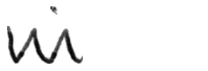

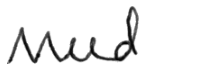

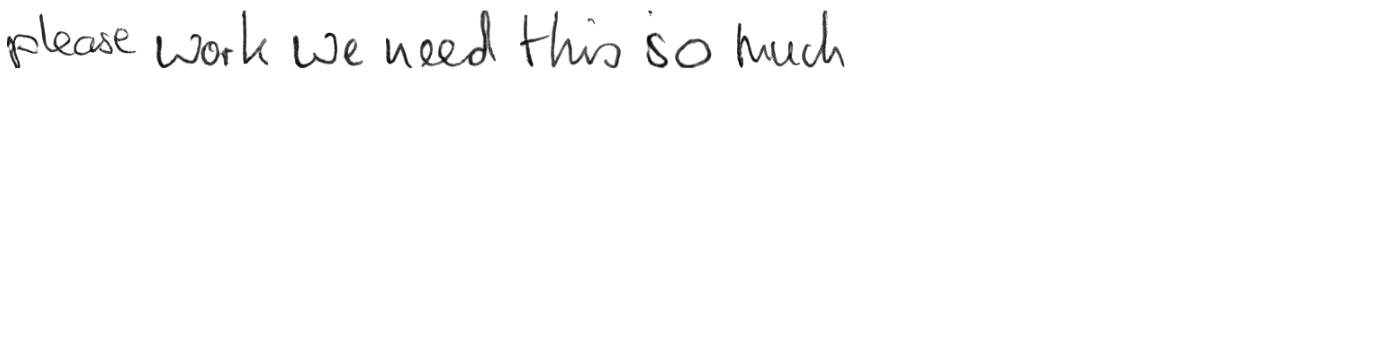

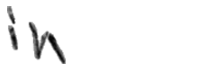

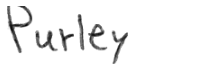

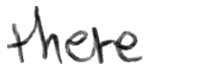

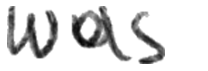

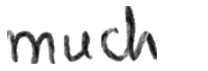

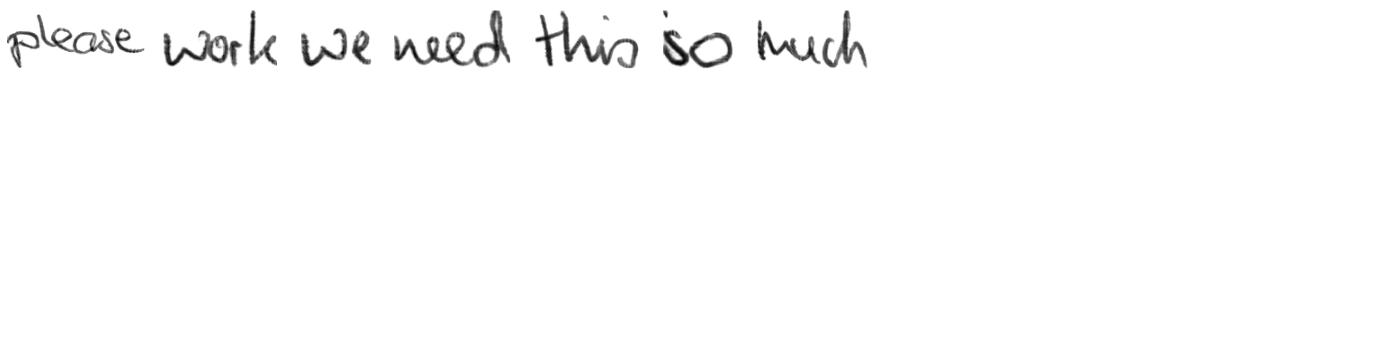

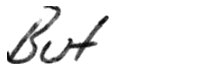

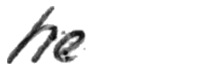

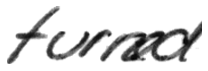

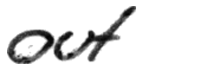

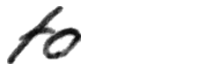

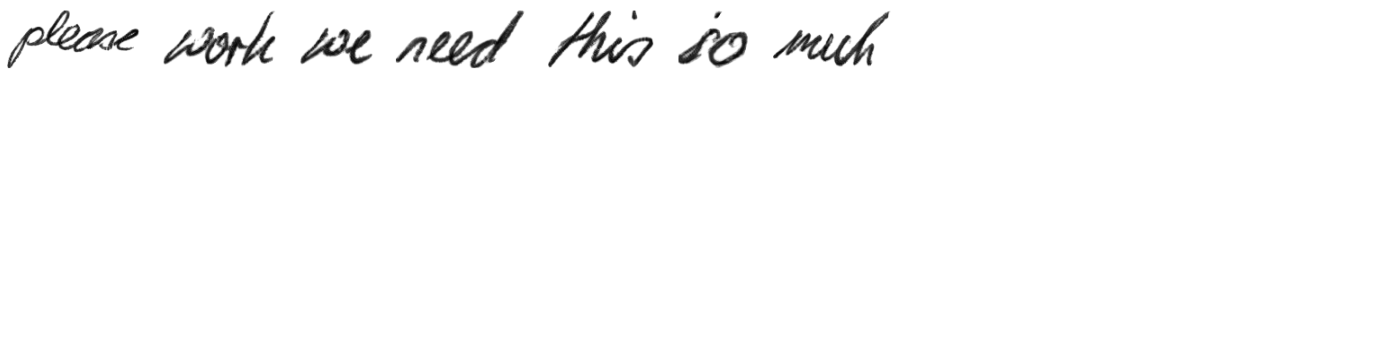

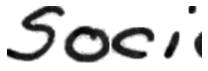

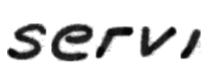

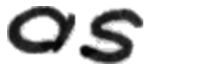

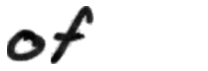

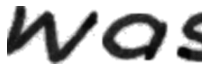

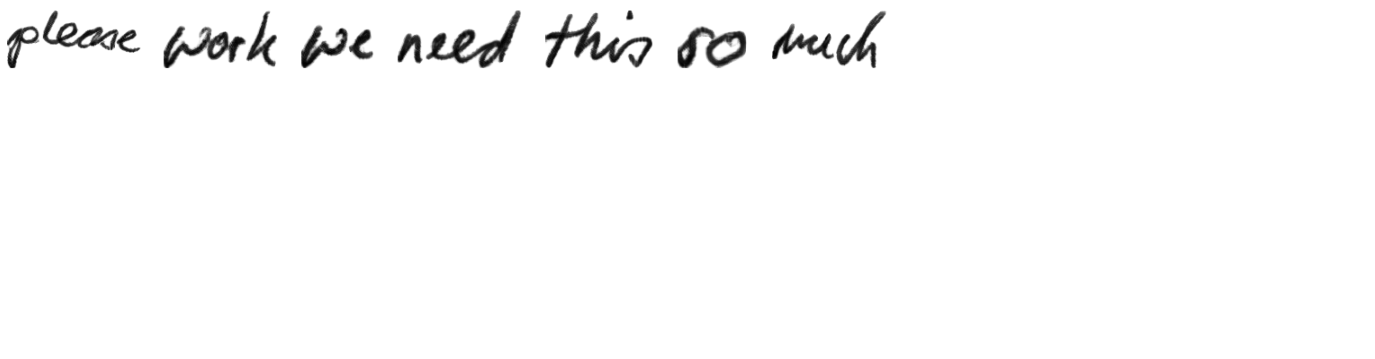

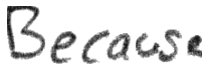

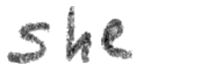

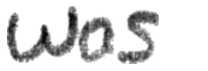

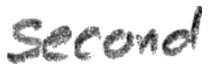

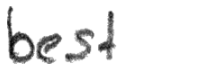

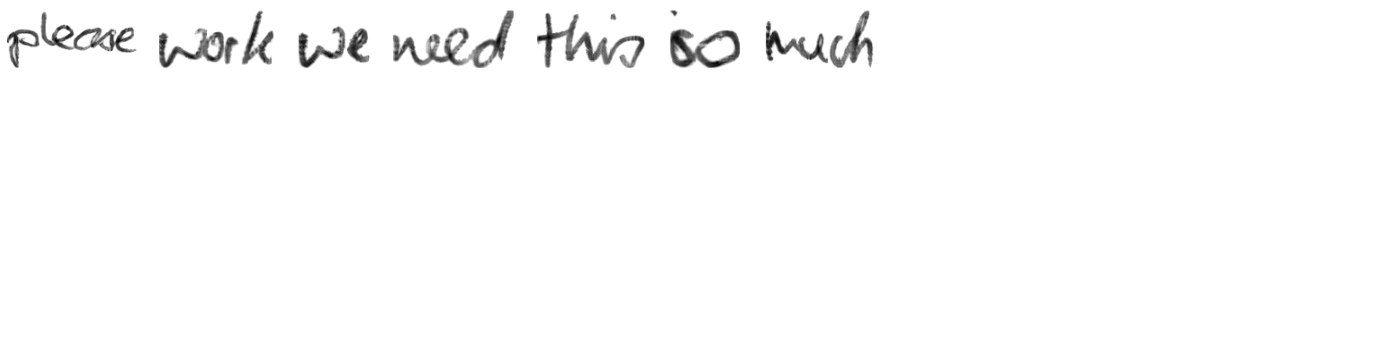

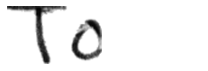

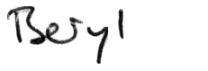

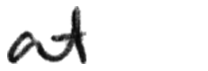

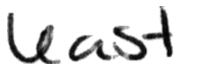

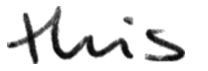

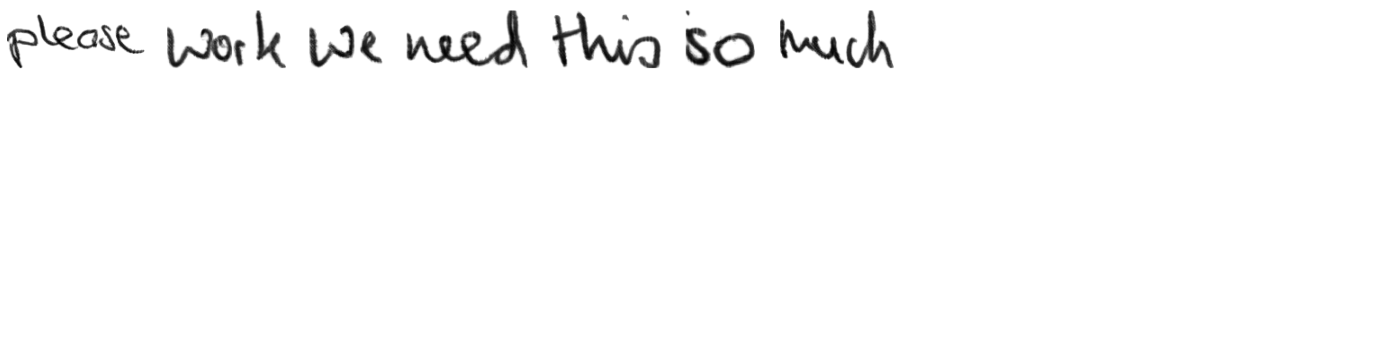

In [ ]:
plt.rcParams["figure.figsize"] = (20,3)

for style_imgs, imgx, locs in zip(styles, words_per_writer, location_per_writer):
  imgx = fix_long_images(imgx, locs)
  crop_images(imgx)
  
  page = np.zeros((64 * 6, 216 * 7))
  page[:] = 255
  add_words(page, imgx)

  # Style images
  for i, style_img in enumerate(style_imgs):
      dpi = 80
      height, width = style_img.shape
      # What size does the figure need to be in inches to fit the image?
      figsize = width / float(dpi), height / float(dpi)
      # Create a figure of the right size with one axes that takes up the full figure
      fig = plt.figure(figsize=figsize)
      ax = fig.add_axes([0, 0, 1, 1])
      # Hide spines, ticks, etc.
      ax.axis('off')
      # Display the image.
      ax.imshow(style_img, cmap='gray')
      plt.show()
      if i >= 4:
          break

  # Generated image
  dpi = 80
  height, width = page.shape
  # What size does the figure need to be in inches to fit the image?
  figsize = width / float(dpi), height / float(dpi)
  # Create a figure of the right size with one axes that takes up the full figure
  fig = plt.figure(figsize=figsize)
  ax = fig.add_axes([0, 0, 1, 1])
  # Hide spines, ticks, etc.
  ax.axis('off')
  # Display the image.
  ax.imshow(page, cmap='gray', vmin=0, vmax=255)
  plt.show()

Plotting of machine learning stats extracted from the training procedure of the generative model

In [ ]:
def plot_stats(path, is_train):
    """ 
    Plots stattistics of model from the given text file by the following order:
    train_stats.txt -->
        1. The discriminator loss on train
        2. The discriminator loss on generator's output
        3. The classifier loss on train
        4. The classifier loss on generator's output
        5. The recognizer loss on train
        6. The recognizer loss on generator's output
        7. The total loss of the models on the generated images
        8. res_cer_tr
        9. res_cer_te
        10. res_cer_te2

    val_stats.txt -->
        1. The discriminator loss on generator's output
        2. The classifier loss on generator's output
        3. The recognizer loss on generator's output
        4. The total loss of the models on the generated images
        5. res_cer_te
        6. res_cer_te2
    """

    stats_len = 10 if is_train else 6
    mod = 5 if is_train else 1
    Y = [[] for i in range(stats_len)]

    with open(path, 'r') as f:
        lines = f.readlines()
        num_epochs = len(lines)

        for i, line in enumerate(lines):
            if i % mod == 0: 
                line_stats = line.split(' ')
                line_stats = [float(val) for val in line_stats]

                for j in range(stats_len):
                    Y[j].append(line_stats[j])
    
    #num_epochs = i if is_train else i+1
    x = [j for j in range(num_epochs) if j % mod == 0] 
    colors = ['#d62728', '#9467bd', '#8c564b', 'b', 'g', 'r', 'k', 'c', 'm', 'y'] # 9 colors

    plt.rcParams["figure.figsize"] = (20, 20)
    fig, ax = plt.subplots(nrows=stats_len // 4 + 1, ncols=4) # create subplot table

    i = 0
    for w, row in enumerate(ax): # plot each graph in the corresponding position in the subplot table
        for h, col in enumerate(row):
            if stats_len > w * 4 + h + 1:
                col.plot(x, Y[i], colors[i])
                i += 1

    plt.setp(ax[-1, :], xlabel='epoch')
    plt.setp(ax[:, 0], ylabel='loss')
    plt.show()

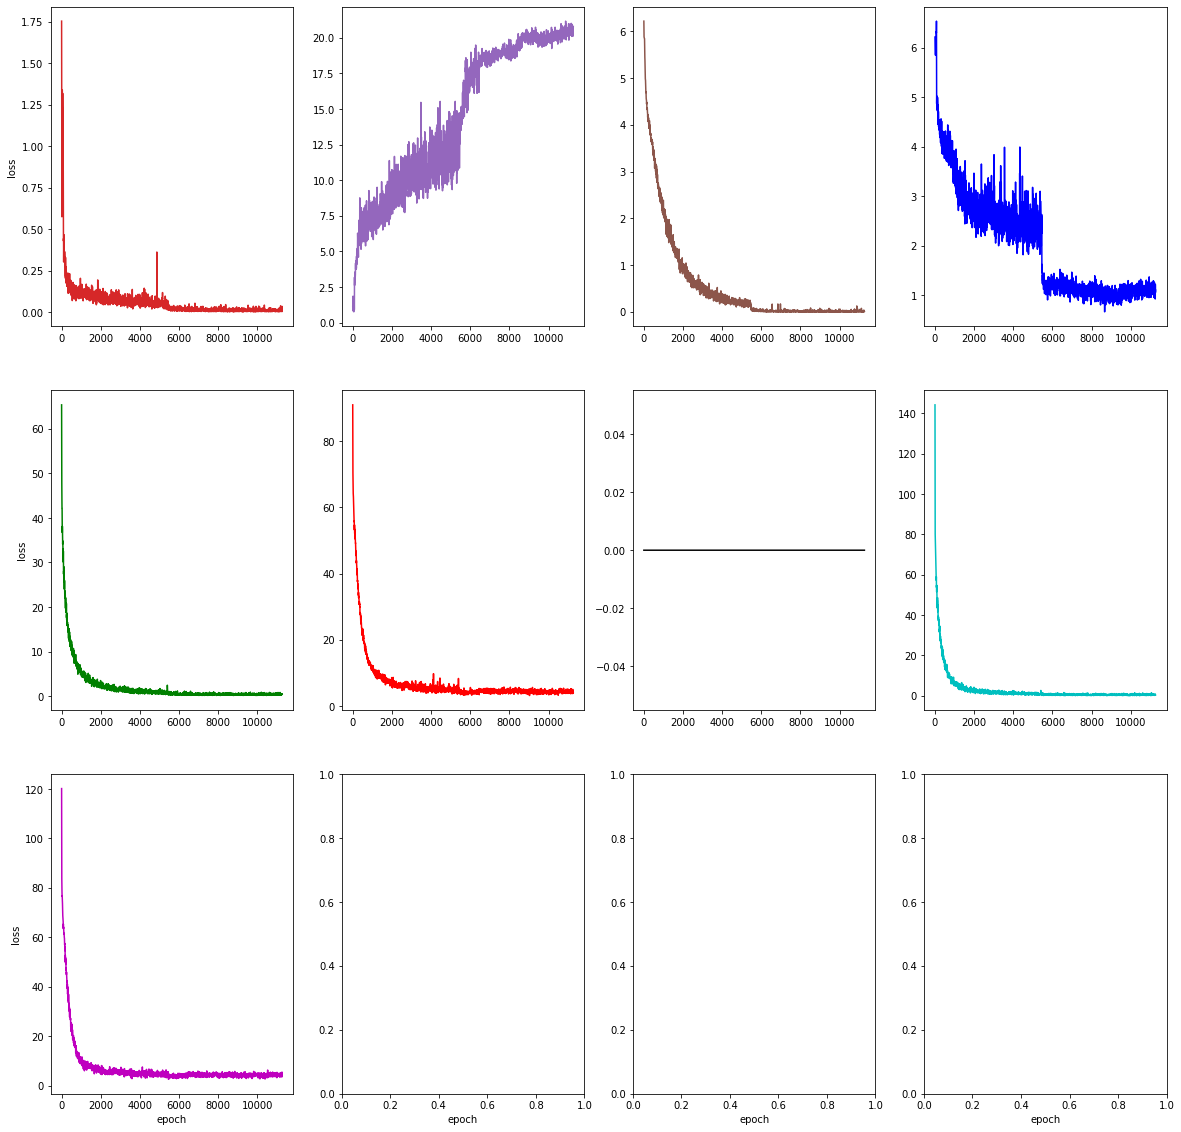

In [ ]:
plot_stats('/content/gdrive/My Drive/Final Project/Models/Handwriting Generation/train_stats.txt', True)

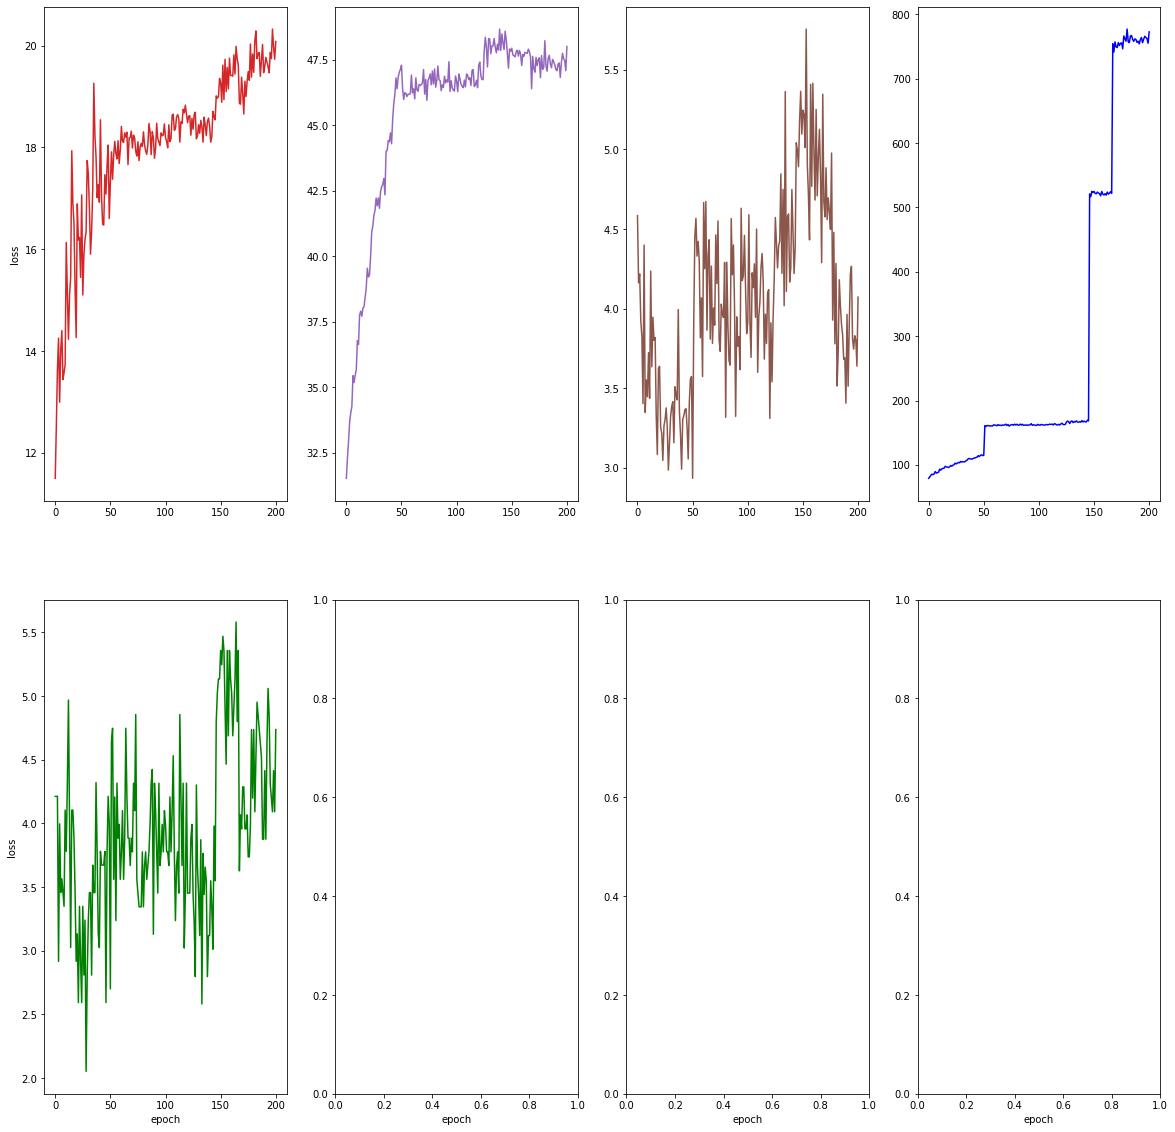

In [ ]:
plot_stats('/content/gdrive/My Drive/Final Projimport cv2
import Levenshtein as Lev
import random
import numpy as np
import torch
from network_tro import ConTranModel
from load_data import IMG_HEIGHT, IMG_WIDTH, NUM_WRITERS, letter2index, tokens, num_tokens, OUTPUT_MAX_LEN, index2letter
from modules_tro import normalize
import matplotlib.pyplot as plt
import os


'''Take turns to open the comments below to run 4 scenario experiments'''
WEIGHTS_PATH  = '/content/gdrive/MyDrive/Final Project/Models/Handwriting Generation/saved_weights/'
# model_path = WEIGHTS_PATH + 'contranCla-6000.model'
model_path = WEIGHTS_PATH + 'contran-10500.model'
# model_path = WEIGHTS_PATH + 'contran-10500Cla-NEW-1000.model'
folder = 'res_1.in_vocab_tr_writer'
img_base    = '/content/fixed_new_words/'
target_file = '/content/research-GANwriting-master/Groundtruth/gan.iam.test.gt.filter27'
text_corpus = '/content/research-GANwriting-master/corpora_english/in_vocab.subset.tro.37'
'''model loading'''
gpu = torch.device('cuda')
model = ConTranModel(500, 0, True).to(gpu)
# model = ConTranModel(1000, 0, True).to(gpu)
print('Loading ' + model_path)
model.load_state_dict(torch.load(model_path)) #load
print('Model loaded')
model.eval();ect/Models/Handwriting Generation/val_stats.txt', False)

# Create fake and real datasets to calculate FID

Define different checkpoint paths to create different fake datasets

In [ ]:
import cv2
import Levenshtein as Lev
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
import os

from glob import glob
from network_tro import ConTranModel
from load_data import IMG_HEIGHT, IMG_WIDTH, NUM_WRITERS, letter2index, tokens, num_tokens, OUTPUT_MAX_LEN, index2letter
from modules_tro import normalize

WEIGHTS_PATH  = '/content/drive/MyDrive/Final Project/Models/Handwriting Generation/saved_weights/'
model_paths = [f'{WEIGHTS_PATH}contran-8000.model', f'{WEIGHTS_PATH}contran-9000.model',
               f'{WEIGHTS_PATH}contran-10500.model']

img_base    = '/content/fixed_new_words/'
target_file = '/content/research-GANwriting-master/Groundtruth/gan.iam.test.gt.filter27'

train_real_paths = '/content/drive/MyDrive/Final Project/Datasets/DeepfakeRecognition/train_real_words'
val_real_paths = '/content/drive/MyDrive/Final Project/Datasets/DeepfakeRecognition/val_real_words'
test_real_paths = '/content/drive/MyDrive/Final Project/Datasets/DeepfakeRecognition/test_real_words'

train_fake_paths = '/content/drive/MyDrive/Final Project/Datasets/DeepfakeRecognition/train_fake_words'
val_fake_paths = '/content/drive/MyDrive/Final Project/Datasets/DeepfakeRecognition/val_fake_words'
test_fake_paths = '/content/drive/MyDrive/Final Project/Datasets/DeepfakeRecognition/test_fake_words'

gpu = torch.device('cuda')

In [ ]:
def clear_ram(obj):
    """ Clears the RAM / Cache and deletes the given model """
    import gc
    obj.cpu()
    del obj # Free obj
    gc.collect() # Free memory in cpu
    torch.cuda.empty_cache() # Free memory in gpu

In [ ]:
from pairs_idx_wid_iam import label2wid_tr, label2wid_te
from tqdm.notebook import trange

batch_size = 8
max_num_samples = 18436 # 18436 is the test size
num_samples = 5000
paths_offset = 0

def create_word_real_fake_ds(wids, texts, img_names, model_paths, src_path, fake_dest_path, real_dest_path, num_samples=5000, paths_offset=0):
    global max_num_samples, batch_size
    assert num_samples<max_num_samples and paths_offset<max_num_samples and (num_samples-paths_offset)<max_num_samples, f'Invalid arguments num_samples={num_samples} and paths_offset={paths_offset}, but max_num_samples={max_num_samples}'

    def read_image(file_name):
        nonlocal src_path
        url = src_path + file_name + '.png'
        img = cv2.imread(url, 0)
       
        rate = float(IMG_HEIGHT) / img.shape[0]
        img = cv2.resize(img, (int(img.shape[1]*rate)+1, IMG_HEIGHT), interpolation=cv2.INTER_CUBIC) # INTER_AREA con error
        img = img/255. # 0-255 -> 0-1

        img = 1. - img
        img_width = img.shape[-1]

        if img_width > IMG_WIDTH:
            outImg = img[:, :IMG_WIDTH]
            img_width = IMG_WIDTH
        else:
            outImg = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype='float32')
            outImg[:, :img_width] = img
        outImg = outImg.astype('float32')

        mean = 0.5
        std = 0.5
        outImgFinal = (outImg - mean) / std
        return outImgFinal

    def label_padding(labels, num_tokens):
        new_label_len = []
        ll = [letter2index[i] for i in labels]
        new_label_len.append(len(ll)+2)
        ll = np.array(ll) + num_tokens
        ll = list(ll)
        ll = [tokens['GO_TOKEN']] + ll + [tokens['END_TOKEN']]
        num = OUTPUT_MAX_LEN - len(ll)
        if not num == 0:
            ll.extend([tokens['PAD_TOKEN']] * num) # replace PAD_TOKEN
        return ll

    '''data preparation'''
    final_img_names = img_names[paths_offset:paths_offset+num_samples]
    imgs = torch.from_numpy(np.array([read_image(name) for name in final_img_names]))
    n, h, w = imgs.shape
    final_images = torch.zeros(n, 50, h, w)
    for i in range(50):
        final_images[:,i,:,:] = imgs
    labels = torch.from_numpy(np.array([np.array(label_padding(label, num_tokens)) for label in texts[paths_offset:paths_offset+num_samples]]))

    single_letter_locations, long_word_locations = list(), list()
    fixed_texts, texts = list(), list()

    num_samples_per_model = len(final_images)//len(model_paths)
    with torch.no_grad():
        for j, model_path in enumerate(model_paths):

            # Current model loading
            print('Loading ' + model_path)
            model = ConTranModel(500, 0, True).to(gpu)
            model.load_state_dict(torch.load(model_path))
            print('Model loaded')
            model.eval();

            for i in trange(j*num_samples_per_model, (j+1)*num_samples_per_model, batch_size):
                batch_imgs = final_images[i:i+batch_size].to(gpu)
                batch_labels = labels[i:i+batch_size].to(gpu)

                f_xs = model.gen.enc_image(batch_imgs)
                f_xt, f_embed = model.gen.enc_text(batch_labels, f_xs.shape)
                f_mix = model.gen.mix(f_xs, f_embed)

                xg = model.gen.decode(f_mix, f_xt).squeeze(1).cpu().numpy()
                xg = 255 - np.asarray([normalize(img) for img in xg])

                batch_imgs = 255 - np.asarray([normalize(img) for img in batch_imgs.cpu().numpy()[:,0,:,:]])
                batch_labels = batch_labels.cpu()
                batch_img_names = final_img_names[i:i+batch_size]

                if not os.path.exists(fake_dest_path):
                    os.makedirs(fake_dest_path)
                if not os.path.exists(real_dest_path):
                    os.makedirs(real_dest_path)

                for fake_img, real_img, img_name in zip(xg, batch_imgs, batch_img_names):
                    cv2.imwrite(f'{fake_dest_path}/{img_name}.png', fake_img)
                    cv2.imwrite(f'{real_dest_path}/{img_name}.png', real_img)

        clear_ram(model)

In [ ]:
data = None
with open(target_file, 'r') as _f:
    data = _f.readlines()

wids = [line.split(',')[0] for line in data]
texts = [line.split(',')[1].split(' ')[1][:-1] for line in data]
img_names = [line.split(',')[1].split(' ')[0] for line in data]

# Create train_fake_paths and train_real_paths datasets

In [ ]:
""" num_samples=5_000, paths_offset=0 """
create_word_real_fake_ds(wids, texts, img_names, model_paths, img_base, train_fake_paths, train_real_paths, 5_000, 0)

Loading /content/drive/MyDrive/Final Project/Models/Handwriting Generation/saved_weights/contran-8000.model
Model loaded



Loading /content/drive/MyDrive/Final Project/Models/Handwriting Generation/saved_weights/contran-9000.model
Model loaded



Loading /content/drive/MyDrive/Final Project/Models/Handwriting Generation/saved_weights/contran-10500.model
Model loaded


In [ ]:
""" num_samples=5_000, paths_offset=5_000 """
create_word_real_fake_ds(wids, texts, img_names, model_paths, img_base, train_fake_paths, train_real_paths, 5_000, 5_000)

Loading /content/drive/MyDrive/Final Project/Models/Handwriting Generation/saved_weights/contran-8000.model
Model loaded



Loading /content/drive/MyDrive/Final Project/Models/Handwriting Generation/saved_weights/contran-9000.model
Model loaded



Loading /content/drive/MyDrive/Final Project/Models/Handwriting Generation/saved_weights/contran-10500.model
Model loaded


In [ ]:
""" num_samples=5_000, paths_offset=10_000 """
create_word_real_fake_ds(wids, texts, img_names, model_paths, img_base, train_fake_paths, train_real_paths, 5_000, 10_000)

Loading /content/drive/MyDrive/Final Project/Models/Handwriting Generation/saved_weights/contran-8000.model
Model loaded



Loading /content/drive/MyDrive/Final Project/Models/Handwriting Generation/saved_weights/contran-9000.model
Model loaded



Loading /content/drive/MyDrive/Final Project/Models/Handwriting Generation/saved_weights/contran-10500.model
Model loaded


In [ ]:
print(f'len(train_fake_paths) = {len(glob(f"{train_fake_paths}/*"))}')
print(f'len(train_real_paths) = {len(glob(f"{train_real_paths}/*"))}')

len(train_fake_paths) = 15000
len(train_real_paths) = 15000


# Create val_fake_paths and val_real_paths datasets

In [ ]:
""" num_samples=1_500, paths_offset=15_000 """
create_word_real_fake_ds(wids, texts, img_names, model_paths, img_base, val_fake_paths, val_real_paths, 1_500, 15_000)

In [ ]:
print(f'len(val_fake_paths) = {len(glob(f"{val_fake_paths}/*"))}')
print(f'len(val_real_paths) = {len(glob(f"{val_real_paths}/*"))}')

len(val_fake_paths) = 1500
len(val_real_paths) = 1500


# Create test_fake_paths and test_real_paths datasets

In [ ]:
""" num_samples=1_500, paths_offset=16_500 """
create_word_real_fake_ds(wids, texts, img_names, model_paths, img_base, test_fake_paths, test_real_paths, 1_500, 16_500)

In [ ]:
print(f'len(test_fake_paths) = {len(glob(f"{test_fake_paths}/*"))}')
print(f'len(test_real_paths) = {len(glob(f"{test_real_paths}/*"))}')

len(test_fake_paths) = 1500
len(test_real_paths) = 1500


In [ ]:
%cd ./fid_folder

/content/research-GANwriting-master/fid_folder


In [ ]:
%cd ..

/content


In [ ]:
!zip -r "/content/RealFakeWordsDS.zip" "./drive/MyDrive/Final Project/Datasets/DeepfakeRecognition"

In [ ]:
!cp "/content/RealFakeWordsDS.zip" "./drive/MyDrive/Final Project/Datasets/DeepfakeRecognition/"

# Calculation of the FID score for this model

In [ ]:
!chmod 777 ./fid.sh
!./fid.sh

/usr/local/lib/python3.6/dist-packages/torchvision/models/inception.py:77: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)
Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:03<00:00, 29.6MB/s]
100% 8/8 [00:02<00:00,  2.96it/s]
100% 8/8 [00:02<00:00,  2.94it/s]
FID:  38.066516026077466
